# ML в Биологии
## 5. Введение в реккурентные нейронные сети

In [3]:
!pip install scikit-image
!pip install lightning
!pip install tensorboard
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.6/565.6 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, \
                             DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
from pylab import rcParams

rcParams['figure.figsize'] = 15, 7
%matplotlib inline

sns.set(font_scale=1.3, palette='Set2')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Данные

## Биология

#### **Профиль биология**

### Загрузка данных
В этом задании вы будете работать с данными о распространении COVID-19, их можно скачать [здесь](https://www.kaggle.com/datasets/gpreda/coronavirus-2019ncov). Мы будем предказывать показатель смертности, потому что способы измерения выздоровевших и заболевших разнятся между регионами.

 В данных представлены следующие столбцы:

* `Country/Region` &mdash; страна или регион,

* `Province/State` &mdash; город или населенный пункт,
* `Latitude` &mdash; географическая широта,
* `Longitude` &mdash; географическая долгота,
* `Confirmed` &mdash; кол-во подтвержденных случаев заболевания,
* `Recovered` &mdash; кол-во подтвержденных случаев выздоровления,
* `Deaths` &mdash; кол-во смертей,
* `Date` &mdash; дата.

Выгрузим датасет.

In [6]:
!unzip archive

Archive:  archive.zip
replace covid-19-all.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: covid-19-all.csv        


In [7]:
df = pd.read_csv('covid-19-all.csv', dtype={'Country/Region': str, 'Province/State': str}, low_memory=False)
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths,Date
0,NaN,NaN,NaN,NaN,51526.0,41727.0,2191.0,2021-01-01
1,NaN,NaN,NaN,NaN,58316.0,33634.0,1181.0,2021-01-01
2,NaN,NaN,NaN,NaN,99897.0,67395.0,2762.0,2021-01-01
3,NaN,NaN,NaN,NaN,8117.0,7463.0,84.0,2021-01-01
4,NaN,NaN,NaN,NaN,17568.0,11146.0,405.0,2021-01-01


Установим в качестве индекса дату.

In [8]:
df.set_index('Date', inplace=True)
df.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths
Date,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,51526.0,41727.0,2191.0
2021-01-01,NaN,NaN,NaN,NaN,58316.0,33634.0,1181.0
2021-01-01,NaN,NaN,NaN,NaN,99897.0,67395.0,2762.0
2021-01-01,NaN,NaN,NaN,NaN,8117.0,7463.0,84.0
2021-01-01,NaN,NaN,NaN,NaN,17568.0,11146.0,405.0


Избавимся от None если они есть.

In [9]:
df.dropna(inplace=True)
df.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,China,Hubei,30.9756,112.2707,444.0,28.0,17.0
2020-01-23,China,Hubei,30.9756,112.2707,444.0,28.0,17.0
2020-01-23,China,Hubei,30.9756,112.2707,444.0,28.0,17.0
2020-01-24,China,Hubei,30.9756,112.2707,549.0,31.0,24.0
2020-01-25,China,Hubei,30.9756,112.2707,761.0,32.0,40.0


Выберем страну и регион, где хотим предсказывать.

In [10]:
country = 'Russia'
region = 'Moscow'

df_selected = df[(df['Country/Region'] == country) & (df['Province/State'] == region)]
df_selected.head()

,Country/Region,Province/State,Latitude,Longitude,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-06-01,Russia,Moscow,55.750446,37.617494,183088.0,82239.0,2553.0
2020-06-02,Russia,Moscow,55.750446,37.617494,185374.0,88269.0,2624.0
2020-06-03,Russia,Moscow,55.750446,37.617494,187216.0,91654.0,2685.0
2020-06-04,Russia,Moscow,55.750446,37.617494,189214.0,94715.0,2749.0
2020-06-05,Russia,Moscow,55.750446,37.617494,191069.0,97358.0,2806.0


Удалим лишние столбцы в выбранных данных.

In [11]:
df_selected = df_selected[['Confirmed', 'Recovered', 'Deaths']]
df_selected.head()

,Confirmed,Recovered,Deaths
Date,,,
2020-06-01,183088.0,82239.0,2553.0
2020-06-02,185374.0,88269.0,2624.0
2020-06-03,187216.0,91654.0,2685.0
2020-06-04,189214.0,94715.0,2749.0
2020-06-05,191069.0,97358.0,2806.0


Посмотрим на данные. Постройте графики заболевших, выздоровевших и количества смертей.

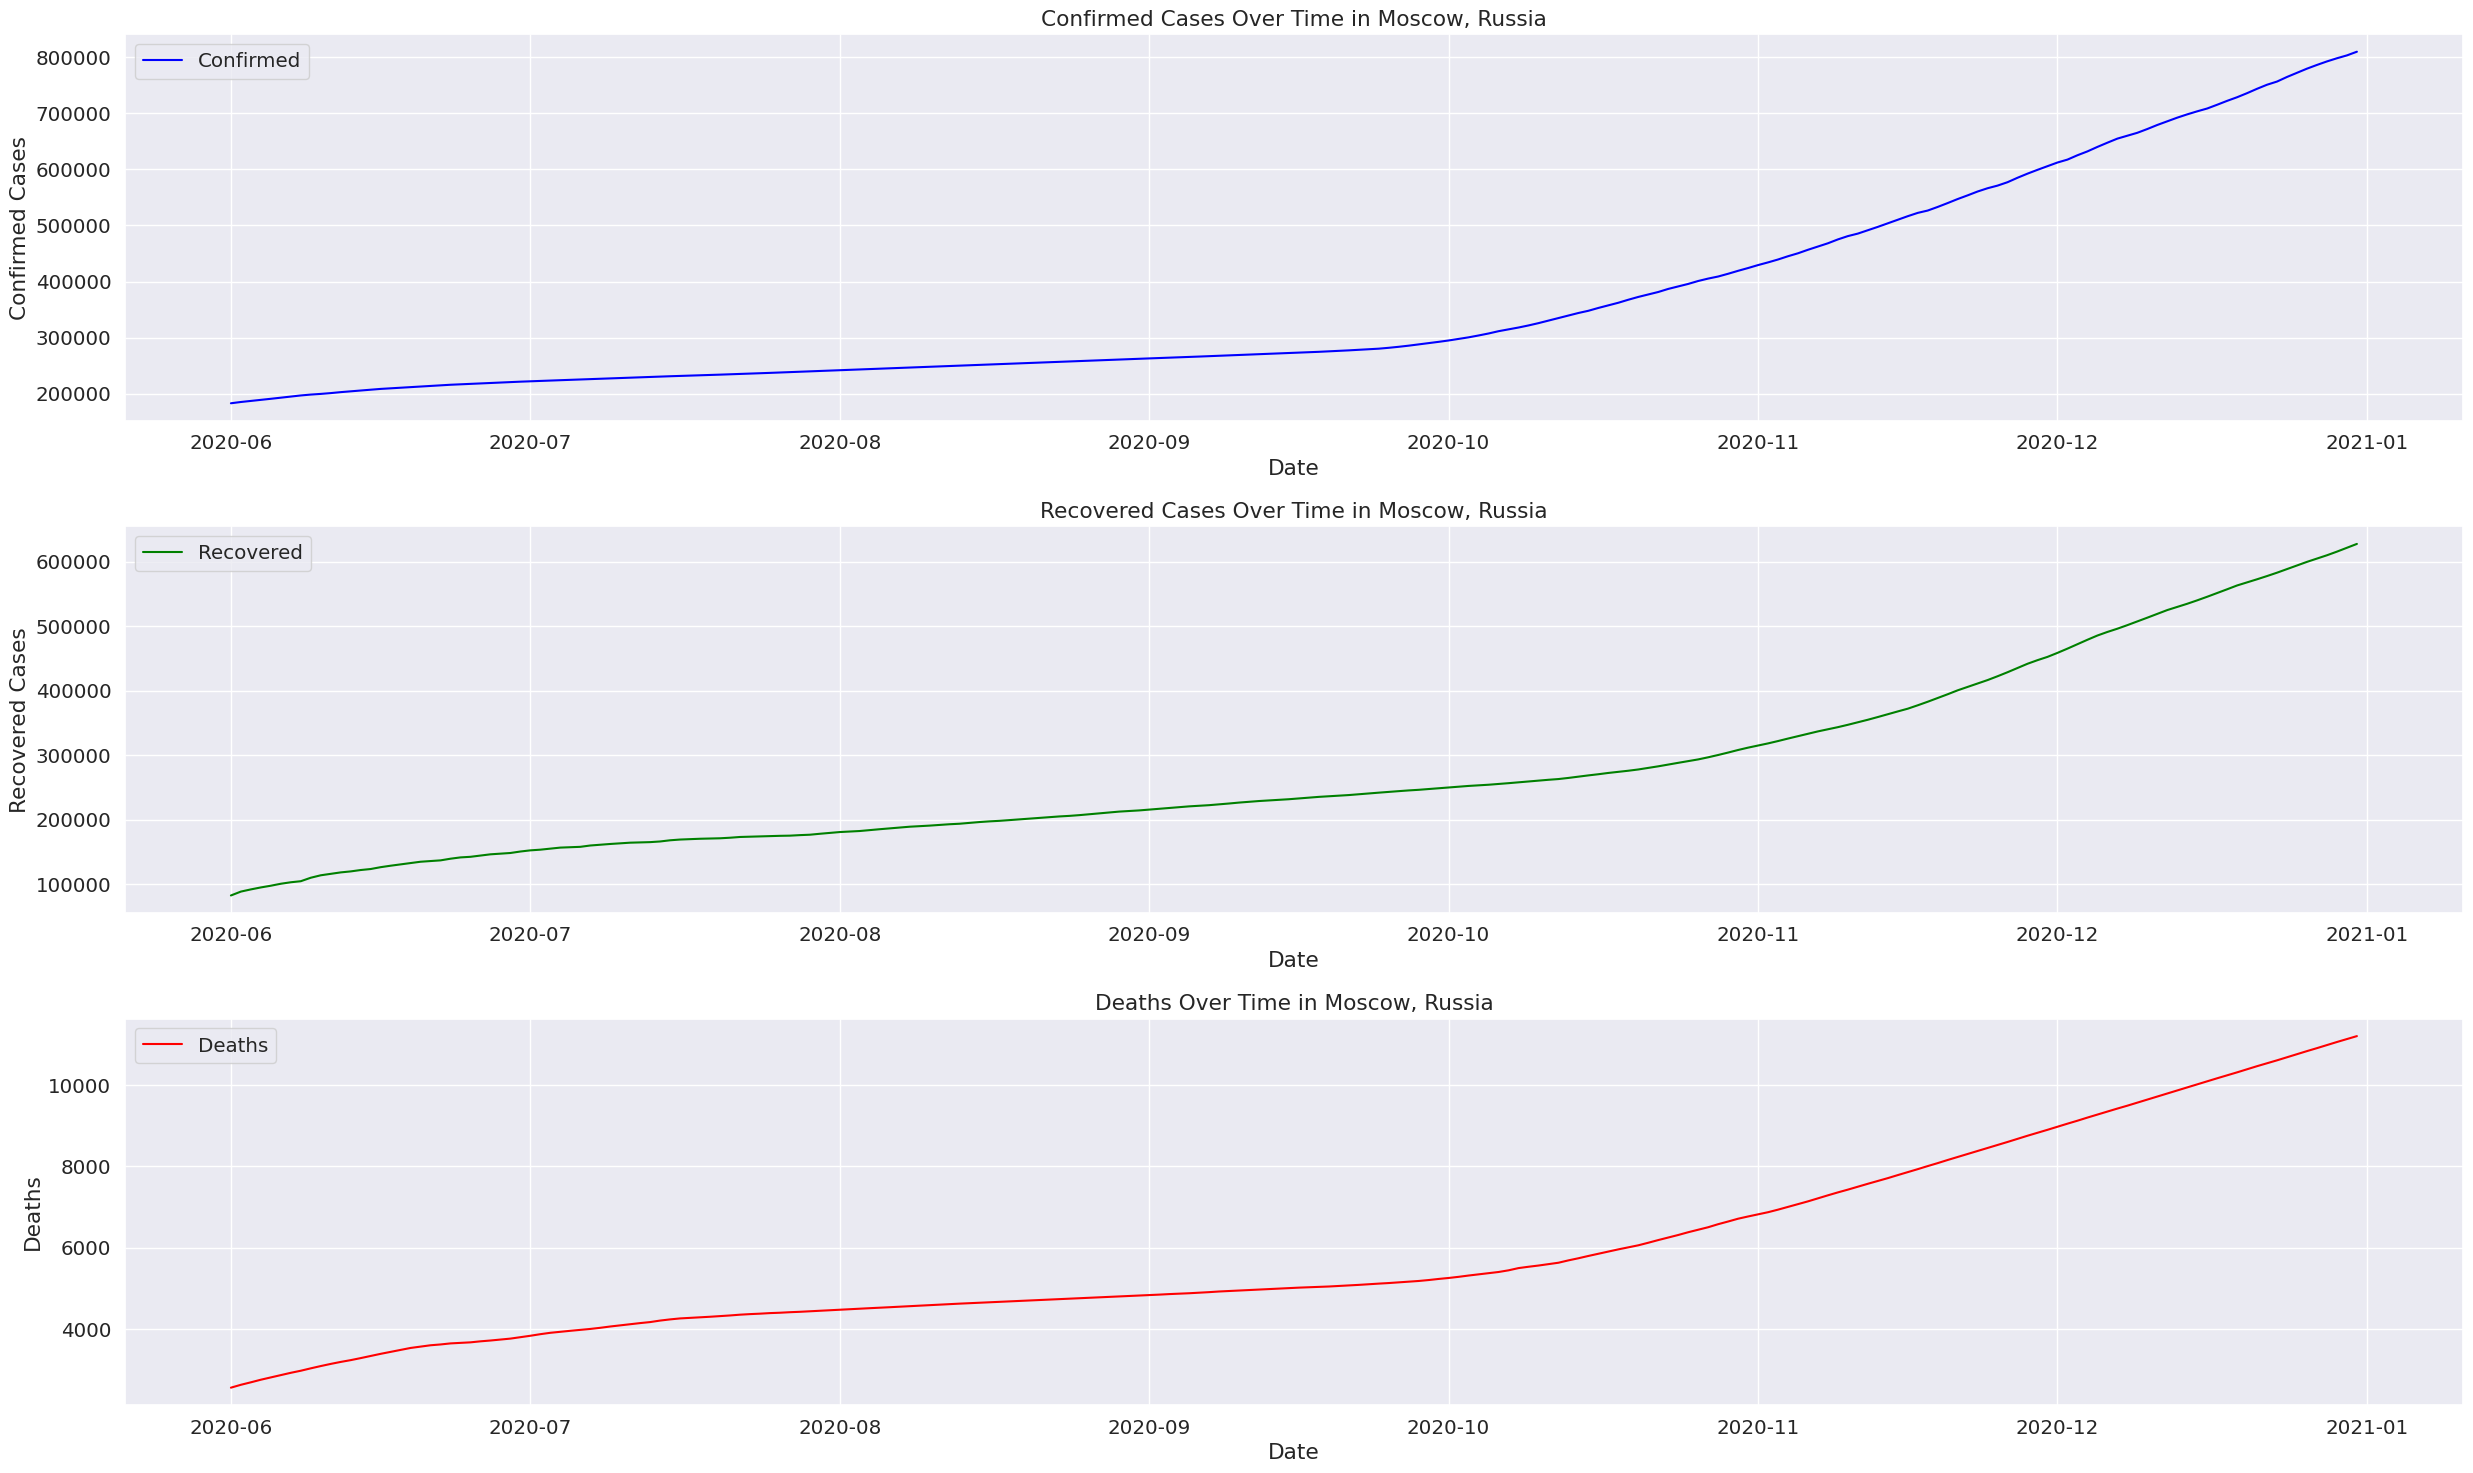

In [13]:
# Построение графиков
plt.figure(figsize=(25, 15))

# График подтвержденных случаев
plt.subplot(3, 1, 1)
plt.plot(df_selected.index, df_selected['Confirmed'], label='Confirmed', color='blue')
plt.title('Confirmed Cases Over Time in Moscow, Russia')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True)

# График выздоровевших
plt.subplot(3, 1, 2)
plt.plot(df_selected.index, df_selected['Recovered'], label='Recovered', color='green')
plt.title('Recovered Cases Over Time in Moscow, Russia')
plt.xlabel('Date')
plt.ylabel('Recovered Cases')
plt.legend()
plt.grid(True)

# График смертей
plt.subplot(3, 1, 3)
plt.plot(df_selected.index, df_selected['Deaths'], label='Deaths', color='red')
plt.title('Deaths Over Time in Moscow, Russia')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.grid(True)

# Отображение графиков
plt.tight_layout()
plt.show()

# Модели и обучение

## Вспомогательные функции

Напишите класс датасета для данных в виде последовательности.

In [14]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, timesteps):
        self.data = data
        self.timesteps = timesteps

    def __len__(self):
        return self.data.shape[0] - self.timesteps

    def __getitem__(self, index):
        return self.data[index:index+self.timesteps], self.data[index+self.timesteps]

Здесь мы создаём функции для обучения, для вывода кривых обучения и для рекурсивного предсказания.

In [15]:
def evaluate_ts_model(model, start_seq, test_data, scaler, return_all=False, device='cpu'):
    '''
    Функция для проверки качества модели на обучающем отрезке ряда.

    :param model: обучаемая модель,
    :param start_seq: обучающие данные для первого предсказания,
    :param test_data: тестовые данные.
    :param return_all: возвращать все предсказания или только для 1-го магазина

    :return: результаты предсказания.
    '''
    result = []
    model.train(False)
    input_tensor = torch.FloatTensor(start_seq).to(device).unsqueeze(0)

    with torch.no_grad():
        for i in range(len(test_data)):
            # делаем предсказание, а unsqueeze нужны, чтобы сделать размерность (1, 1, 1) вместо (1)

            logits = model(input_tensor[:, i:, :]).unsqueeze(0)#.unsqueeze(2)

            # присоединяем предсказанное значение к последовательности:
            #                        (1, timestep, 1) -> (1, 1, 1)   по оси 1
            input_tensor = torch.cat((input_tensor,        logits),       1    )

            # обратное преобразование к нормальным числам
            logits = scaler.inverse_transform(logits.cpu().numpy().squeeze(0))

            # результат сохраняем
            result.append(logits.squeeze())

    if return_all:
        return np.array(result)

    return np.array(result)

Создадим класс модели.

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_lstm_layers, use_pool=False):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_lstm_layers
        self.input_size  = input_size

        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True,
                            dropout=0.2) # LSTM-модель с batch_first=True и dropout=0.2

        # Размерность пространства выхода последнего LSTM-слоя равна hidden_size.
        # Линейный слой нужен, чтобы преобразовать выход LSTM к нужному размеру output_size.
        self.fc = nn.Linear(in_features=hidden_size,
                            out_features=output_size) # добавьте линейный слой

        # Пуллинг
        self.pool = nn.AdaptiveAvgPool1d(1) # добавьте усредняющий все выходы пуллинг-слой
        self.use_pool = use_pool


    def forward(self, input_seq):

        # инициализируем начальные скрытые состояния
        h_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(device=input_seq.device)
        c_0 = torch.zeros(self.num_layers, input_seq.size(0), self.hidden_size).to(device=input_seq.device)

        out, (_, _) = self.lstm(input_seq, (h_0, c_0))

        if self.use_pool:
            # берем среднее от векторов для всей последовательности
            out_to_fc = self.pool(out.transpose(1, 2)).squeeze(-1)
        else:
            # берем последний выходной вектор
            out_to_fc = out[:, -1, :]

        return self.fc(out_to_fc)

Напишем функцию для визуализации результатов предсказания.

In [17]:
def plot_results(y_to_train, y_to_test=None, y_forecast=None):
    """
        Функция для визуализации временного ряда и предсказания.

        Параметры:
            - y_to_train: pd.Series
                Временной ряд, на котором обучалась модель.
            - y_to_test: pd.Series
                Временной ряд, который предсказывает модель.
            - y_forecast: array
                Предсказания модели.
            - plot_conf_int: bool
                Надо ли строить предсказательного интервал.
            - left_bound: array
                Левая граница предсказательного интервала.
            - right_bound: array
                Правая граница предсказательного интервала.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(y_to_train)), y_to_train, label='train')

    if y_to_test is not None:
        plt.plot(np.arange(len(y_to_train), len(y_to_train) + len(y_to_test)), y_to_test,  label='test')
        if y_forecast is not None:
            plt.plot(np.arange(len(y_to_train), len(y_to_train) + len(y_to_test)), y_forecast, label='prediction')
    plt.legend()
    plt.show()

## Биология

Разделим выборку на тест и трейн.

In [18]:
test_time = pd.Timestamp('2020-12-01')
train_bio = df_selected[df_selected.index < test_time]['Deaths'].values.reshape(-1, 1)
test_bio = df_selected[df_selected.index >= test_time]['Deaths'].values.reshape(-1, 1)
train_bio.shape, test_bio.shape

((183, 1), (31, 1))

Посмотрим на то, что получилось.

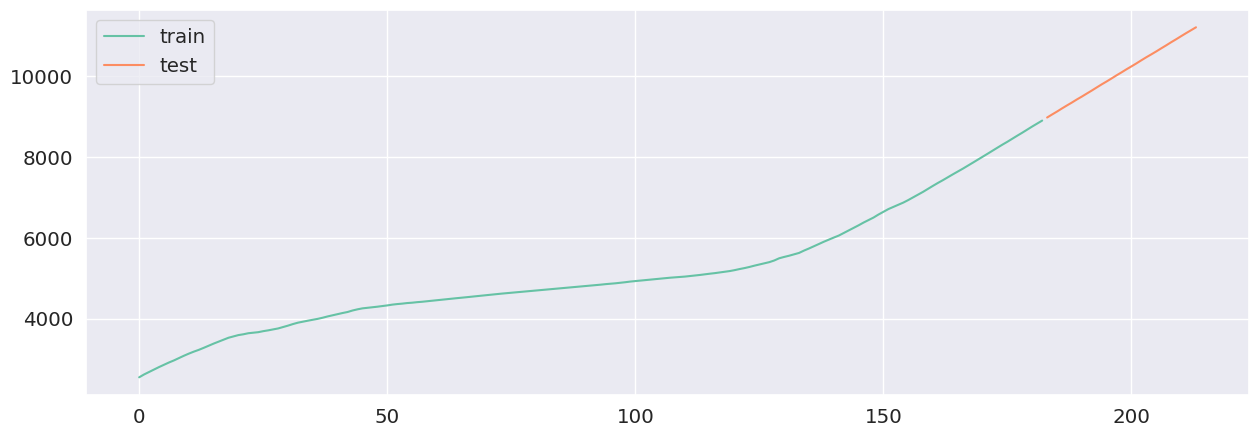

In [19]:
plot_results(train_bio, test_bio)

Преобразуем данные.

In [20]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_bio)

Зададим длину подпоследовательности, размер батча, девайс.

In [40]:
timesteps = 5
batch_size = 32

Преобразуем к датасету с помощью нашего класса и сделаем генератор батчей.

In [41]:
train_dataset = TSDataset(train_scaled, timesteps)
test_dataset = TSDataset(scaler.transform(test_bio), timesteps)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

Инициализируем модель.

In [42]:
class TSModel(pl.LightningModule):
    def __init__(self, model, lr=5e-4):
        super().__init__()
        self.lr = lr
        self.criterion = nn.MSELoss()
        self.save_hyperparameters()
        self.model = model
        self.predictions = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        output = self.forward(x_batch)
        loss = self.criterion(output.squeeze(), y_batch.squeeze())
        self.log('train_loss', loss)
        return loss

    def training_step(self, batch, batch_idx):
        x_batch, y_batch = batch
        output = self.forward(x_batch)
        loss = self.criterion(output.squeeze(), y_batch.squeeze())
        self.log('val_loss', loss)
        return loss

    def transfer_batch_to_device(self, batch, device, dataloader_idx):
        x_batch, y_batch = batch
        x_batch = x_batch.type(torch.float32).to(device)
        y_batch = y_batch.type(torch.float32).to(device)
        return x_batch, y_batch

In [43]:
lstm_1 = LSTM(
            input_size=1,
            output_size=1,
            hidden_size=50,
            num_lstm_layers=2,
            use_pool=False
            )

lstm_model_1 = TSModel(
                    model=lstm_1,
                    lr=5e-4,
                    )

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [46]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='max')
tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/lstm_1")

trainer = pl.Trainer(logger=tb_logger,
                     accelerator='gpu',
                     max_epochs=1000,
                     devices=1,
                     val_check_interval=5,
                     callbacks=[checkpoint_callback])

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Создадим предсказания на тесте.

In [47]:
trainer.fit(lstm_model_1, train_batch_gen, test_batch_gen)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 31.1 K | train
----------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | criterion | MSELoss | 0      | train
1 | model     | LSTM    | 31.1 K | train
----------------------------------------------
31.1 K    Trainable params
0         Non-trainable params
31.1 K    Total params
0.124     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1000` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


Сравним предсказание с реальностью.

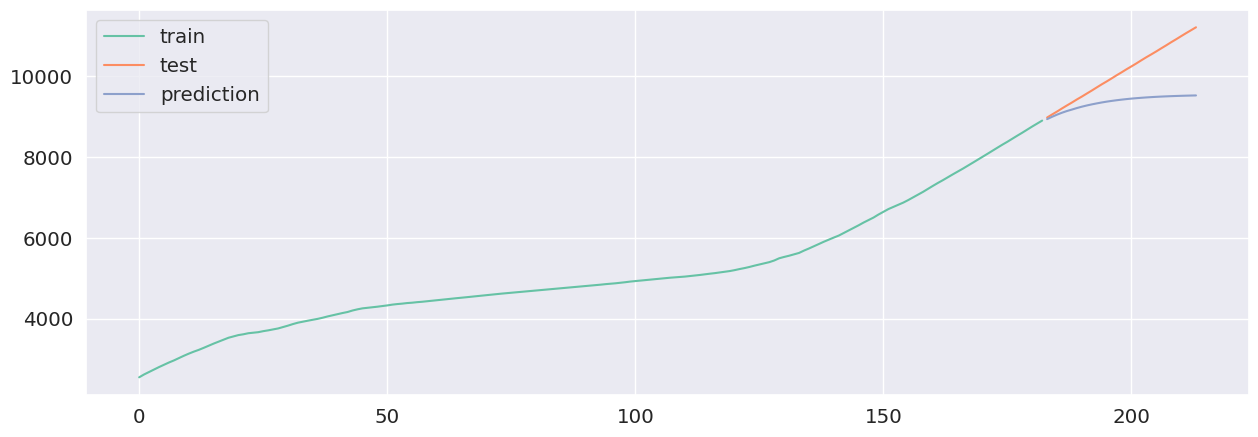

In [48]:
lstm_model_1.cpu()
start_seq = train_scaled[-timesteps:]
test_pred = evaluate_ts_model(lstm_model_1, start_seq, scaler.transform(test_bio), scaler)
plot_results(train_bio, test_bio, test_pred)

In [52]:
#%reload_ext tensorboard
#%tensorboard --logdir=lightning_logs/lstm_1

**Вывод:**

1. **Общая тенденция**:
   - График показывает, что модель в целом неплохо схватывает общую тенденцию изменений в количестве смертей. Однако предсказания значительно отклоняются от реальных данных в определенные моменты времени.

2. **Анализ предсказаний**:
   - Линия реальных значений, как правило, сохраняет более стабильный, линейный тренд, в то время как предсказания имеют логарифмический характер.
   - Предсказанные значения имеют значительные колебания, что может говорить о недостаточной адаптивности модели к изменяющимся условиям в течение времени.

3. **Периоды несоответствия**:
   - На графике можно заметить конкретные временные отрезки, где предсказания значительно расходятся с реальными данными. Это может указывать на влияние внешних факторов (например, всплески заболеваемости, изменения в политике, массовая вакцинация), которые модель не учла.

4. **Заключение**:
   - В общем, модель предоставляет полезные предсказания, но требует дальнейшего дообучения и адаптации для достижения большей точности.